Processed output_0: Uncertainty 1 mean=1.4796512679333074, Uncertainty 2 mean=3.989753103648345, Uncertainty 3 mean=1.4796512679333074
Processed output_1: Uncertainty 1 mean=1.7129268790562509, Uncertainty 2 mean=3.64796343355927, Uncertainty 3 mean=1.7129268790562509
Processed output_2: Uncertainty 1 mean=0.5004667669268507, Uncertainty 2 mean=3.793252057318595, Uncertainty 3 mean=0.5004667669268507
Processed output_3: Uncertainty 1 mean=1.3683769788972642, Uncertainty 2 mean=3.6702601242018087, Uncertainty 3 mean=1.3683769788972642
Processed output_4: Uncertainty 1 mean=1.5173026056876706, Uncertainty 2 mean=3.9764301276933725, Uncertainty 3 mean=1.5173026056876706
Processed output_5: Uncertainty 1 mean=1.616236118590753, Uncertainty 2 mean=3.5936979826158844, Uncertainty 3 mean=1.616236118590753
Processed output_6: Uncertainty 1 mean=1.6842592809026573, Uncertainty 2 mean=3.9972731556519827, Uncertainty 3 mean=1.6842592809026573
Processed output_7: Uncertainty 1 mean=2.2626415731634

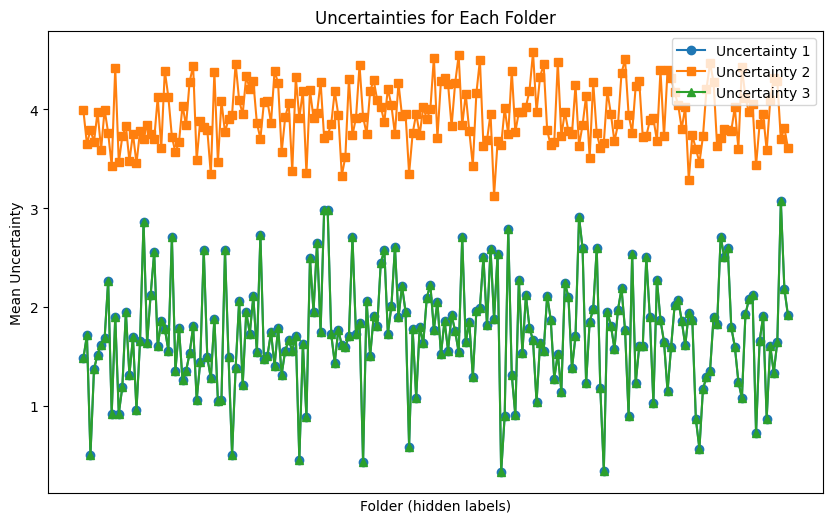

Uncertainty Summary Statistics:
       mean_uncertainty_1  mean_uncertainty_2  mean_uncertainty_3
count          200.000000          200.000000          200.000000
mean             1.729562            3.929360            1.729562
std              0.547860            0.302287            0.547860
min              0.323953            3.126890            0.323953
25%              1.425213            3.725423            1.425213
50%              1.725471            3.908897            1.725471
75%              1.995026            4.184489            1.995026
max              3.067938            4.576368            3.067938
Uncertainty results saved to fisher_uncertainties_regularized.csv


In [1]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic regularization term function
def get_dynamic_epsilon(matrix):
    cond_number = np.linalg.cond(matrix)
    eigvals = np.linalg.eigvals(matrix)
    eigval_std = np.std(eigvals)
    
    if cond_number > 1e20 or eigval_std > 1e2:
        return 1e-2
    elif cond_number > 1e16 or eigval_std > 1e1:
        return 1e-3
    elif cond_number > 1e12:
        return 1e-4
    else:
        return 1e-6

# Enhanced eigenvalue clipping to ensure positive definiteness
def ensure_positive_definite(matrix, matrix_name=""):
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals_clipped = np.clip(eigvals, 1e-2, 1e3)
    matrix_pos_def = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
    return matrix_pos_def

# Regularize matrix
def regularize_matrix(matrix, matrix_name=""):
    epsilon = get_dynamic_epsilon(matrix)
    matrix_sym = (matrix + matrix.T) / 2
    return ensure_positive_definite(matrix_sym + epsilon * np.eye(matrix.shape[0]), matrix_name)

# Compute covariance matrix
def compute_covariance(fisher_matrix, matrix_name=""):
    reg_matrix = regularize_matrix(fisher_matrix, matrix_name)
    cov_matrix = np.linalg.pinv(reg_matrix)
    return cov_matrix

# Compute uncertainties (square root of diagonal of covariance matrix)
def compute_uncertainties(cov_matrix):
    uncertainties = np.sqrt(np.diag(cov_matrix))
    return uncertainties

# Process all folders and compute covariance matrices and uncertainties
def process_all_folders(base_dir):
    results = []
    
    for i in range(200):  # Restrict range to 0 to 199
        folder_path = os.path.join(base_dir, f'output_{i}', 'R_ET_1_ET_2_ET_3')
        pkl_file_path = os.path.join(folder_path, 'R_ET_1_ET_2_ET_3_0.pkl')
        
        if not os.path.exists(pkl_file_path):
            print(f"File {pkl_file_path} not found, skipping.")
            continue
        
        with open(pkl_file_path, 'rb') as file:
            data = pickle.load(file)

        fisher_matrix_1 = data[1]
        fisher_matrix_2 = data[2][0]
        fisher_matrix_3 = data[2][1]

        # Compute covariance matrices
        cov_matrix_1 = compute_covariance(fisher_matrix_1, "matrix_1")
        cov_matrix_2 = compute_covariance(fisher_matrix_2, "matrix_2")
        cov_matrix_3 = compute_covariance(fisher_matrix_3, "matrix_3")

        # Compute uncertainties
        uncertainties_1 = compute_uncertainties(cov_matrix_1)
        uncertainties_2 = compute_uncertainties(cov_matrix_2)
        uncertainties_3 = compute_uncertainties(cov_matrix_3)

        results.append({
            'folder': f'output_{i}',
            'uncertainties_1': uncertainties_1,
            'uncertainties_2': uncertainties_2,
            'uncertainties_3': uncertainties_3
        })
        
        print(f"Processed output_{i}: Uncertainty 1 mean={np.mean(uncertainties_1)}, Uncertainty 2 mean={np.mean(uncertainties_2)}, Uncertainty 3 mean={np.mean(uncertainties_3)}")
    
    return results

# Save results to a CSV file
def save_results_to_csv(results, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['folder', 'uncertainties_1', 'uncertainties_2', 'uncertainties_3'])
        for result in results:
            writer.writerow([result['folder'], ','.join(map(str, result['uncertainties_1'])), ','.join(map(str, result['uncertainties_2'])), ','.join(map(str, result['uncertainties_3']))])

# Read CSV and visualize
def visualize_uncertainties(csv_file):
    data = pd.read_csv(csv_file)
    
    # Convert uncertainty strings separated by commas into numeric values
    def convert_to_numeric_list(uncertainty_str):
        return list(map(float, uncertainty_str.split(',')))
    
    data['uncertainties_1'] = data['uncertainties_1'].apply(convert_to_numeric_list)
    data['uncertainties_2'] = data['uncertainties_2'].apply(convert_to_numeric_list)
    data['uncertainties_3'] = data['uncertainties_3'].apply(convert_to_numeric_list)
    
    # Calculate the mean uncertainty for each folder
    data['mean_uncertainty_1'] = data['uncertainties_1'].apply(np.mean)
    data['mean_uncertainty_2'] = data['uncertainties_2'].apply(np.mean)
    data['mean_uncertainty_3'] = data['uncertainties_3'].apply(np.mean)
    
    # Plot the comparison of uncertainties
    plt.figure(figsize=(10, 6))
    plt.plot(data['folder'], data['mean_uncertainty_1'], label='Uncertainty 1', marker='o')
    plt.plot(data['folder'], data['mean_uncertainty_2'], label='Uncertainty 2', marker='s')
    plt.plot(data['folder'], data['mean_uncertainty_3'], label='Uncertainty 3', marker='^')
    
    # Hide x-axis labels
    plt.xticks([])

    plt.title('Uncertainties for Each Folder')
    plt.xlabel('Folder (hidden labels)')
    plt.ylabel('Mean Uncertainty')
    plt.legend(loc='upper right')
    plt.show()

    # Compute summary statistics for uncertainties
    summary_stats = data[['mean_uncertainty_1', 'mean_uncertainty_2', 'mean_uncertainty_3']].describe()

    print("Uncertainty Summary Statistics:")
    print(summary_stats)

# Main program
if __name__ == "__main__":
    base_dir = "/Users/ciel/ET/KL_test_200Mpc"
    output_file = "fisher_uncertainties_regularized.csv"
    
    # Process all folders and save results
    results = process_all_folders(base_dir)
    save_results_to_csv(results, output_file)
    
    # Read the saved file and perform visual analysis
    visualize_uncertainties(output_file)
    
    print(f"Uncertainty results saved to {output_file}")
